# Determining the cost of cars

A service for selling used cars is developing an application to attract new customers, where you can quickly estimate the market value of your car. Historical data is at our disposal: technical characteristics, configurations and prices of cars. I need to build a model to determine the cost.

The following are important to the customer:

- quality of prediction;
- prediction speed;
- training time.

## Data preparation

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

from datetime import datetime

In [2]:
data = pd.read_csv('/datasets/autos.csv', parse_dates=[0])
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  object        
 13  NumberOfPictures   354369 non-null  int64   

In [5]:
data[['DateCreated', 'LastSeen']] = data[['DateCreated', 'LastSeen']].astype('datetime64')
data.dtypes

DateCrawled          datetime64[ns]
Price                         int64
VehicleType                  object
RegistrationYear              int64
Gearbox                      object
Power                         int64
Model                        object
Kilometer                     int64
RegistrationMonth             int64
FuelType                     object
Brand                        object
Repaired                     object
DateCreated          datetime64[ns]
NumberOfPictures              int64
PostalCode                    int64
LastSeen             datetime64[ns]
dtype: object

In [6]:
data[['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Repaired', 'Model']].nunique()

VehicleType      8
Gearbox          2
FuelType         7
Brand           40
Repaired         2
Model          250
dtype: int64

In [7]:
for column in ['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Repaired', 'Model']:
    display(pd.DataFrame(data[column].value_counts(normalize=True).mul(100)).style.background_gradient())

,VehicleType
sedan,28.861805
small,25.192897
wagon,20.564948
bus,9.080753
convertible,6.375620
coupe,5.100685
suv,3.785672
other,1.037620


,Gearbox
manual,80.185989
auto,19.814011


,FuelType
petrol,67.299999
gasoline,30.708549
lpg,1.651767
cng,0.175753
hybrid,0.072479
other,0.063458
electric,0.027996


,Brand
volkswagen,21.732431
opel,11.268198
bmw,10.416825
mercedes_benz,9.043116
audi,8.312240
ford,7.105305
renault,5.058851
peugeot,3.103545
fiat,2.721175
seat,1.949098


,Repaired
no,87.269742
yes,12.730258


,Model
golf,8.734731
other,7.297170
3er,5.904728
polo,3.904214
corsa,3.756006
astra,3.229807
passat,3.031697
a4,2.958191
c_klasse,2.483685
5er,2.351015


In [8]:
sorted(data['Model'].dropna().unique())

['100',
 '145',
 '147',
 '156',
 '159',
 '1_reihe',
 '1er',
 '200',
 '2_reihe',
 '300c',
 '3_reihe',
 '3er',
 '4_reihe',
 '500',
 '5_reihe',
 '5er',
 '601',
 '6_reihe',
 '6er',
 '7er',
 '80',
 '850',
 '90',
 '900',
 '9000',
 '911',
 'a1',
 'a2',
 'a3',
 'a4',
 'a5',
 'a6',
 'a8',
 'a_klasse',
 'accord',
 'agila',
 'alhambra',
 'almera',
 'altea',
 'amarok',
 'antara',
 'arosa',
 'astra',
 'auris',
 'avensis',
 'aveo',
 'aygo',
 'b_klasse',
 'b_max',
 'beetle',
 'berlingo',
 'bora',
 'boxster',
 'bravo',
 'c1',
 'c2',
 'c3',
 'c4',
 'c5',
 'c_klasse',
 'c_max',
 'c_reihe',
 'caddy',
 'calibra',
 'captiva',
 'carisma',
 'carnival',
 'cayenne',
 'cc',
 'ceed',
 'charade',
 'cherokee',
 'citigo',
 'civic',
 'cl',
 'clio',
 'clk',
 'clubman',
 'colt',
 'combo',
 'cooper',
 'cordoba',
 'corolla',
 'corsa',
 'cr_reihe',
 'croma',
 'crossfire',
 'cuore',
 'cx_reihe',
 'defender',
 'delta',
 'discovery',
 'doblo',
 'ducato',
 'duster',
 'e_klasse',
 'elefantino',
 'eos',
 'escort',
 'espace',
 

In [9]:
(data
 .loc[data['Model'].isin(['range_rover', 'range_rover_evoque', 'range_rover_sport', 'rangerover']), ['Model', 'Price']]
 .groupby('Model')
 .agg({'count', 'mean', 'median'})
)

Price                     
                   count median          mean
Model                                        
range_rover           77   5999   7401.935065
range_rover_evoque     2  12500  12500.000000
range_rover_sport     54  15350  15332.796296
rangerover             4   2900   5937.500000

In [10]:
data['Model'].where(data['Model'] != 'rangerover', 'range_rover', inplace=True)

In [11]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [12]:
for column in ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired']:
    data[column].fillna(data[column].mode().iloc[0], inplace=True)
data.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

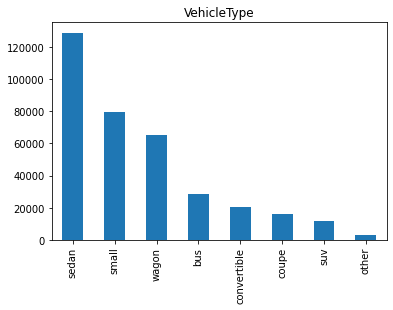

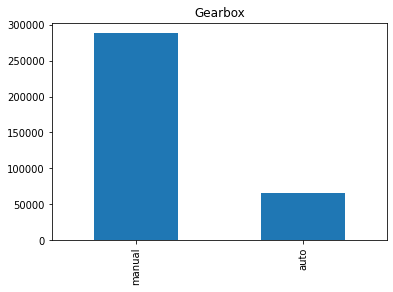

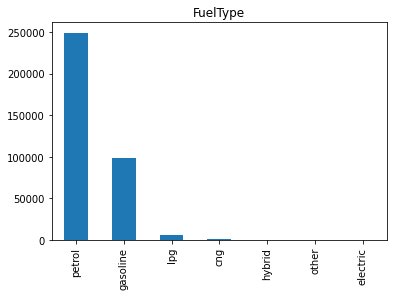

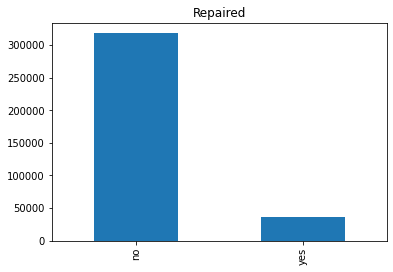

In [13]:
for column in ['VehicleType', 'Gearbox', 'FuelType', 'Repaired']:
    pd.DataFrame(data[column].value_counts()).plot(kind='bar', legend=None)
    plt.title(column)
    plt.show()

In [14]:
data.dtypes

DateCrawled          datetime64[ns]
Price                         int64
VehicleType                  object
RegistrationYear              int64
Gearbox                      object
Power                         int64
Model                        object
Kilometer                     int64
RegistrationMonth             int64
FuelType                     object
Brand                        object
Repaired                     object
DateCreated          datetime64[ns]
NumberOfPictures              int64
PostalCode                    int64
LastSeen             datetime64[ns]
dtype: object

In [15]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


In [16]:
data.drop(columns=['RegistrationMonth', 'NumberOfPictures'], inplace=True)

<AxesSubplot:xlabel='Price', ylabel='Density'>

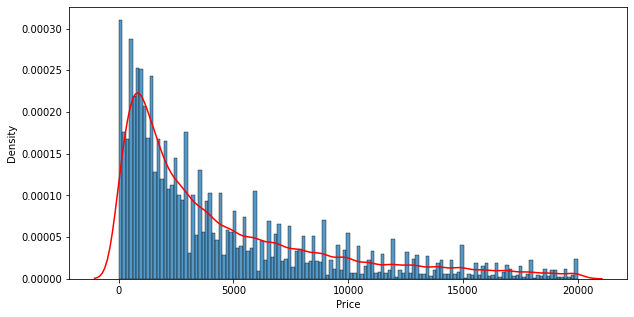

In [17]:
plt.figure(figsize=(10, 5))

ax = sns.histplot(data['Price'], stat='density')
sns.kdeplot(data['Price'], color='red', ax=ax);

In [18]:
data.skew()

Price                1.430609
RegistrationYear    74.621005
Power               60.157196
Kilometer           -1.724119
PostalCode           0.077054
dtype: float64

In [19]:
data['Price'].quantile(0.05)

200.0

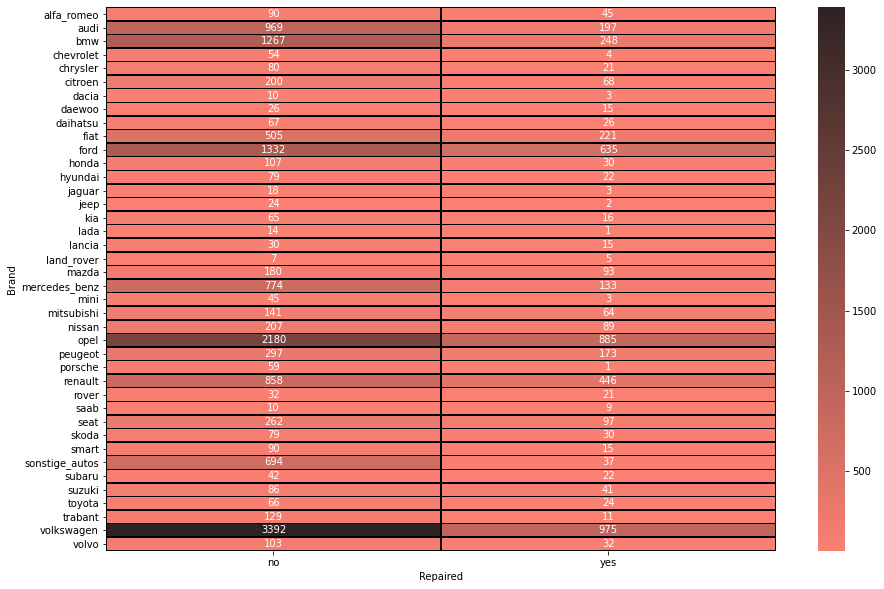

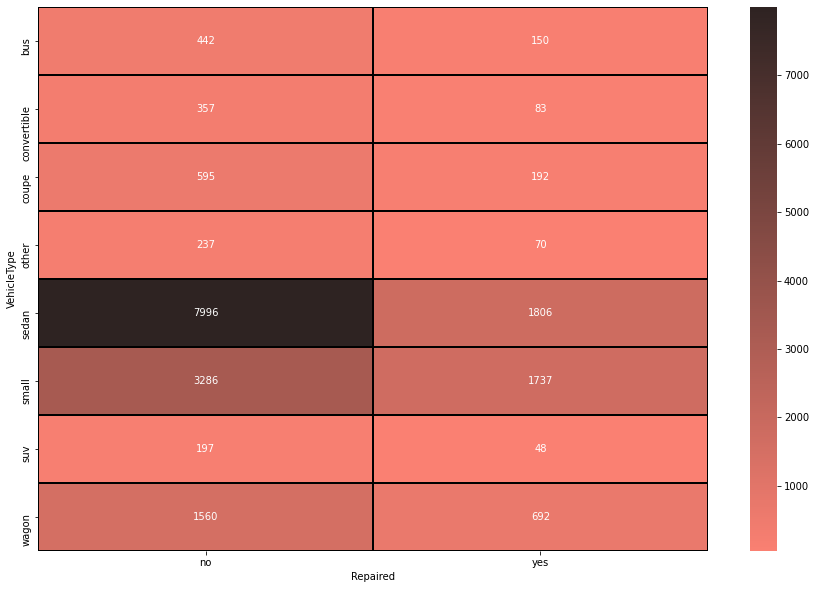

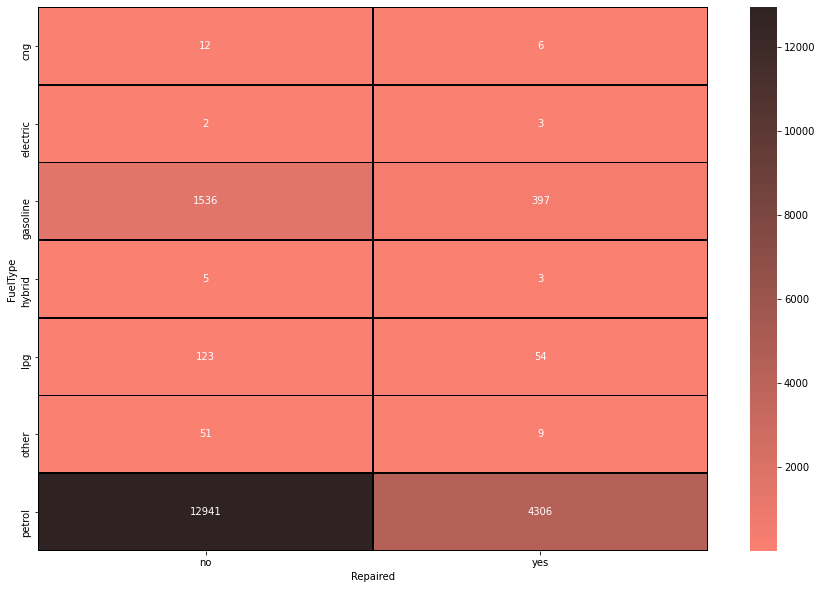

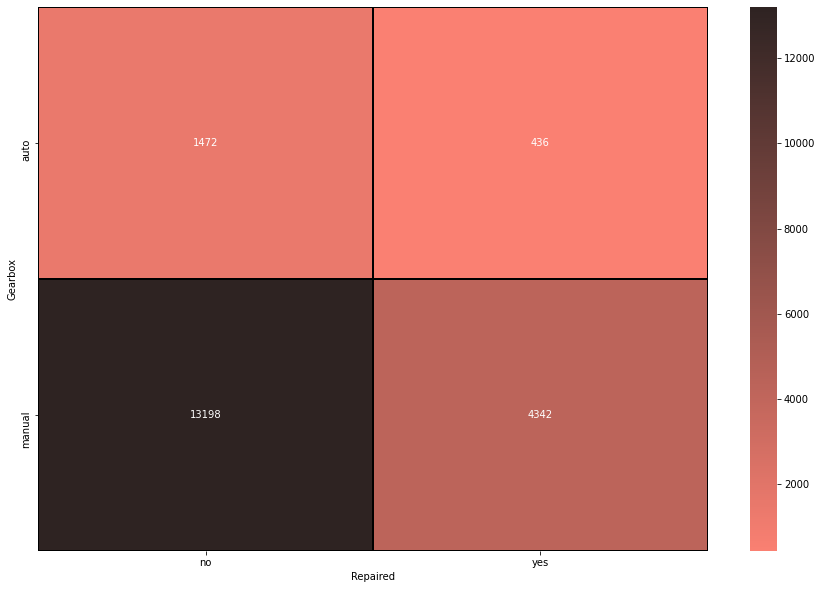

In [20]:
for index in ['Brand', 'VehicleType', 'FuelType', 'Gearbox']:
    plt.figure(figsize=(15, 10))
    sns.heatmap(
        data[data['Price'] <= data['Price'].quantile(0.05)]
        .pivot_table(
            index=index, 
            columns='Repaired', 
            values='Price', 
            aggfunc='count'),
         annot=True, fmt='g',
         linewidth=0.5, linecolor='black', cmap=sns.color_palette("dark:salmon_r", as_cmap=True)
    )
    plt.show()

In [21]:
data = data[data['Price'] > data['Price'].quantile(0.05)]

In [22]:
data.shape

(334921, 14)

In [23]:
def iqr(column):
    iqr = data[column].quantile(0.75) - data[column].quantile(0.25)
    lower = data[column].quantile(0.25) - 1.5*iqr
    upper = data[column].quantile(0.75) + 1.5*iqr
    return lower, upper


lower, upper = iqr('RegistrationYear')
print(lower, upper)

1985.5 2021.5


In [24]:
data = data[(data['RegistrationYear'] >= lower) & (data['RegistrationYear'] <= upper)]

In [25]:
len(data)

329440

In [26]:
lower, upper = iqr('Power')
print(lower, upper)

-27.0 245.0


In [27]:
data = data[(data['Power'] != 0) & (data['Power'] <= 245)]

In [28]:
len(data)

289947

In [29]:
print('Spearman')
display(data.corr(method='spearman'))
print('Pearson')
data.corr()

Spearman


,Price,RegistrationYear,Power,Kilometer,PostalCode
Price,1.000000,0.645320,0.506092,-0.381637,0.062117
RegistrationYear,0.645320,1.000000,0.150855,-0.382371,0.029301
Power,0.506092,0.150855,1.000000,0.121345,0.063797
Kilometer,-0.381637,-0.382371,0.121345,1.000000,-0.018616
PostalCode,0.062117,0.029301,0.063797,-0.018616,1.000000


Pearson


,Price,RegistrationYear,Power,Kilometer,PostalCode
Price,1.000000,0.529967,0.489080,-0.410741,0.062961
RegistrationYear,0.529967,1.000000,0.112437,-0.349737,0.021161
Power,0.489080,0.112437,1.000000,0.111525,0.060992
Kilometer,-0.410741,-0.349737,0.111525,1.000000,-0.012492
PostalCode,0.062961,0.021161,0.060992,-0.012492,1.000000


In [30]:
data = data.drop(columns='PostalCode')

<Figure size 1080x720 with 0 Axes>

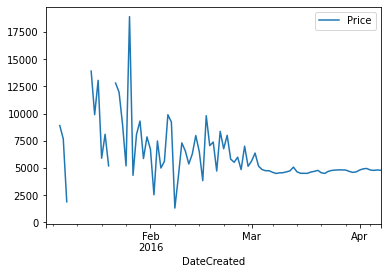

<Figure size 1080x720 with 0 Axes>

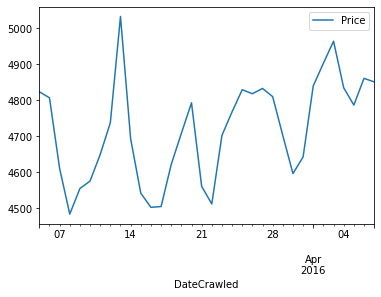

<Figure size 1080x720 with 0 Axes>

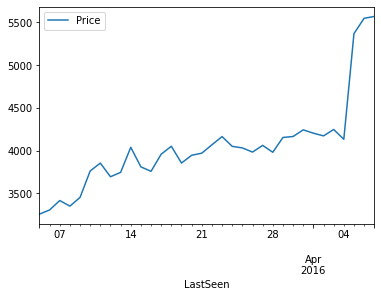

In [31]:
for column in ['DateCreated', 'DateCrawled', 'LastSeen']:
    plt.figure(figsize=(15, 10))
    data[[column, 'Price']].set_index(column).sort_index()['2016': ].resample('1D').mean().plot()
    plt.show()

In [32]:
data.drop(columns=['DateCreated', 'DateCrawled', 'LastSeen'], inplace=True)

In [33]:
data.duplicated().sum()

47896

In [34]:
data.drop_duplicates(inplace=True)
data.shape

(242051, 10)

In [35]:
data.reset_index(drop=True, inplace=True)

In [36]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,242051.0,4859.626525,4513.064098,202.0,1450.0,3250.0,6950.0,20000.0
RegistrationYear,242051.0,2003.932915,6.233800,1986.0,2000.0,2004.0,2008.0,2019.0
Power,242051.0,117.820715,44.864393,1.0,80.0,113.0,147.0,245.0
Kilometer,242051.0,126978.033555,37475.474164,5000.0,125000.0,150000.0,150000.0,150000.0


In [37]:
data.skew()

Price               1.328982
RegistrationYear    0.056316
Power               0.537402
Kilometer          -1.552133
dtype: float64

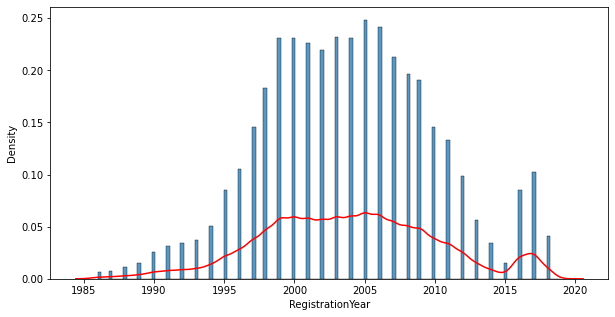

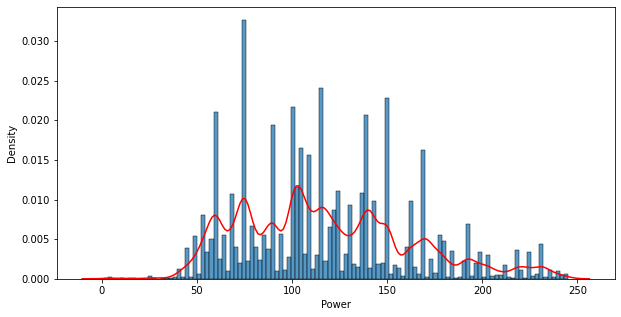

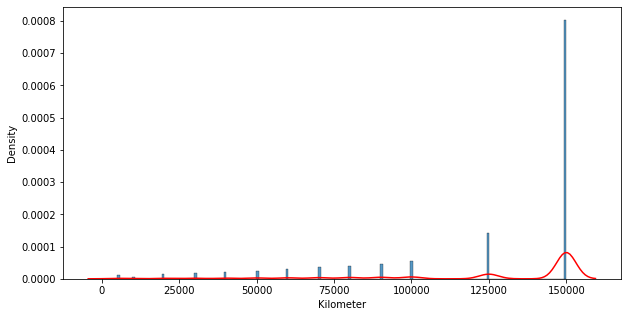

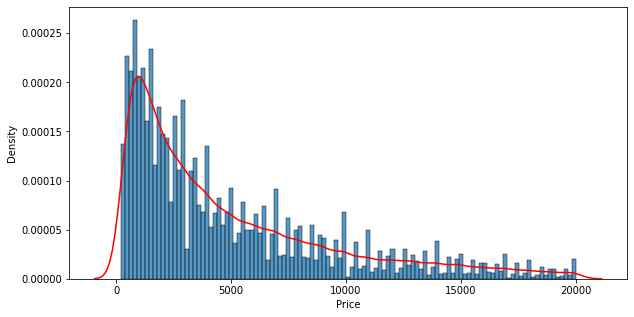

In [38]:
for column in ['RegistrationYear', 'Power', 'Kilometer', 'Price']:
    plt.figure(figsize=(10, 5))
    ax = sns.histplot(data[column], stat='density')
    sns.kdeplot(data[column], color='red', ax=ax)
    plt.show()

In [39]:
features = data.drop(columns='Price')
target = data['Price']

features_train, features_valid, target_train, target_valid =\
    train_test_split(features, target, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test =\
    train_test_split(features_valid, target_valid, test_size=0.5, random_state=12345)

In [40]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
features_train.loc[:, ['Model', 'Brand', 'VehicleType', 'FuelType', 'Gearbox', 'Repaired']] =\
    encoder.fit_transform(features_train[['Model', 'Brand', 'VehicleType', 'FuelType', 'Gearbox', 'Repaired']])
features_valid.loc[:, ['Model', 'Brand', 'VehicleType', 'FuelType', 'Gearbox', 'Repaired']] =\
    encoder.transform(features_valid[['Model', 'Brand', 'VehicleType', 'FuelType', 'Gearbox', 'Repaired']])
features_test.loc[:, ['Model', 'Brand', 'VehicleType', 'FuelType', 'Gearbox', 'Repaired']] =\
    encoder.transform(features_test[['Model', 'Brand', 'VehicleType', 'FuelType', 'Gearbox', 'Repaired']])


#scaler = StandardScaler()
#target_train = scaler.fit_transform(target_train.values.reshape(-1, 1))
#target_valid = scaler.transform(target_valid.values.reshape(-1, 1))
#target_test = scaler.transform(target_test.values.reshape(-1, 1))


minmax = MinMaxScaler()
features_train.loc[:, ['RegistrationYear', 'Power', 'Kilometer']] =\
    minmax.fit_transform(features_train[['RegistrationYear', 'Power', 'Kilometer']])
features_valid.loc[:, ['RegistrationYear', 'Power', 'Kilometer']] =\
    minmax.transform(features_valid[['RegistrationYear', 'Power', 'Kilometer']])
features_test.loc[:, ['RegistrationYear', 'Power', 'Kilometer']] =\
    minmax.transform(features_test[['RegistrationYear', 'Power', 'Kilometer']])

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


**Description of the first stage:**

1. A total of 6 columns were deleted:

    RegistrationMonth: Column values ​​range from 0 to 12, meaning some months were recorded from 0 to 11 and others were recorded from 1 to 12. There is no explicit way to clean the data of such inaccuracies that could negatively impact the model. Moreover, there is no reason to believe that the month a car is registered affects its price today. Therefore, it was decided to remove this column.
    
    DateCreated, DateCrawled and LastSeen do not explain either annual or seasonal trends, as they only cover a few months of 2016. Moreover, it is impossible to explain the dependence of price on such parameters.
    
    PostalCode correlates very weakly with the price of the car. Pearson and Spearman correlation coefficients are only 6%.
    
    NumberOfPictures only accepts zero values, so it does not carry additional information.
    
    
2. RegistrationYear has been cleared of such absurd values as 9999 registration year.


3. Power and Price were cleaned of near-zero values. Additionally, only cars with no more than 245 hp were kept, since the rest are outside the normal limits.


4. Missing values for categorical variables were replaced by mode in the corresponding column.


5. Duplicates in the data were removed and re-indexed. The implicit duplicates of rangerover and range_rover have also been processed.


6. The following are most represented in the sample

    car body types: sedan, small, wagon;
    
    models: golf, 3er, polo;
    
    brands: volkswagen, opel, bmw.
    
    Most of these cars run on gasoline, have a manual transmission and have not been repaired.
    
    
7. Prices for the presented cars are normally distributed with a mean of 4075, a median of 2550, a standard deviation of 4041 and a skewness coefficient of 1.62. The remaining features are not normally distributed.


8. The sample is divided into training, validation and test samples in a ratio of 60:20:20. Categorical features were coded ordinally, quantitative features were scaled.

## Model training

In [41]:
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 10,
    'learning_rate': 0.05,
    'metric': 'rmse',
    'verbose': -1
}


lgb_train = lgb.Dataset(features_train, target_train)
lgb_eval = lgb.Dataset(features_valid, target_valid, reference=lgb_train)

start = datetime.now()
model_gbdt = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=30)
stop = datetime.now()
execution_time = stop - start

print('Время обучения:', execution_time)

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's rmse: 4365.58
Training until validation scores don't improve for 30 rounds
[2]	valid_0's rmse: 4235
[3]	valid_0's rmse: 4113.31
[4]	valid_0's rmse: 3995.58
[5]	valid_0's rmse: 3888.49
[6]	valid_0's rmse: 3775.3
[7]	valid_0's rmse: 3675.65
[8]	valid_0's rmse: 3574.57
[9]	valid_0's rmse: 3480.24
[10]	valid_0's rmse: 3396.63
[11]	valid_0's rmse: 3314.78
[12]	valid_0's rmse: 3242.37
[13]	valid_0's rmse: 3169.66
[14]	valid_0's rmse: 3106.33
[15]	valid_0's rmse: 3042.73
[16]	valid_0's rmse: 2983.42
[17]	valid_0's rmse: 2930.22
[18]	valid_0's rmse: 2876.01
[19]	valid_0's rmse: 2825.44
[20]	valid_0's rmse: 2781.88
[21]	valid_0's rmse: 2741.03
[22]	valid_0's rmse: 2699.5
[23]	valid_0's rmse: 2657.53
[24]	valid_0's rmse: 2623.27
[25]	valid_0's rmse: 2586.89
[26]	valid_0's rmse: 2556.33
[27]	valid_0's rmse: 2525.96
[28]	valid_0's rmse: 2498.27
[29]	valid_0's rmse: 2469.31
[30]	valid_0's rmse: 2446.69
[31]	valid_0's rmse: 2421.21
[32]	valid_0's rmse: 2400.48
[33]	valid_0's rmse: 2380

In [42]:
params = {
    'task': 'train', 
    'boosting': 'dart',
    'objective': 'regression',
    'num_leaves': 10,
    'learning_rate': 0.05,
    'metric': 'rmse',
    'verbose': -1
}


lgb_train = lgb.Dataset(features_train, target_train)
lgb_eval = lgb.Dataset(features_valid, target_valid, reference=lgb_train)

start = datetime.now()
model_dart = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval)
stop = datetime.now()
execution_time = stop - start
print(execution_time)

[1]	valid_0's rmse: 4365.58
[2]	valid_0's rmse: 4235
[3]	valid_0's rmse: 4113.31
[4]	valid_0's rmse: 3995.58
[5]	valid_0's rmse: 3888.49
[6]	valid_0's rmse: 3775.3
[7]	valid_0's rmse: 3675.65
[8]	valid_0's rmse: 3717.86
[9]	valid_0's rmse: 3613.22
[10]	valid_0's rmse: 3516.66
[11]	valid_0's rmse: 3434.82
[12]	valid_0's rmse: 3466.05
[13]	valid_0's rmse: 3379.11
[14]	valid_0's rmse: 3302.9
[15]	valid_0's rmse: 3226.06
[16]	valid_0's rmse: 3158.18
[17]	valid_0's rmse: 3090.24
[18]	valid_0's rmse: 3030.31
[19]	valid_0's rmse: 2970.24
[20]	valid_0's rmse: 2916.36
[21]	valid_0's rmse: 2934.06
[22]	valid_0's rmse: 2883.87
[23]	valid_0's rmse: 2833.96
[24]	valid_0's rmse: 2785.72
[25]	valid_0's rmse: 2743.92
[26]	valid_0's rmse: 2702.44
[27]	valid_0's rmse: 2665.47
[28]	valid_0's rmse: 2684.23
[29]	valid_0's rmse: 2644.32
[30]	valid_0's rmse: 2610.6
[31]	valid_0's rmse: 2619.39
[32]	valid_0's rmse: 2582.04
[33]	valid_0's rmse: 2552.1
[34]	valid_0's rmse: 2520.76
[35]	valid_0's rmse: 2540.48
[

In [43]:
params = {
    'task': 'train', 
    'boosting': 'goss',
    'objective': 'regression',
    'num_leaves': 10,
    'top_rate': 0.1,
    'learning_rate': 0.05,
    'metric': 'rmse',
    'verbose': -1
}


lgb_train = lgb.Dataset(features_train, target_train)
lgb_eval = lgb.Dataset(features_valid, target_valid, reference=lgb_train)

start = datetime.now()
model_goss = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval)
stop = datetime.now()
execution_time = stop - start
print(execution_time)

[1]	valid_0's rmse: 4365.58
[2]	valid_0's rmse: 4235
[3]	valid_0's rmse: 4113.31
[4]	valid_0's rmse: 3995.58
[5]	valid_0's rmse: 3888.49
[6]	valid_0's rmse: 3775.3
[7]	valid_0's rmse: 3675.65
[8]	valid_0's rmse: 3574.57
[9]	valid_0's rmse: 3480.24
[10]	valid_0's rmse: 3396.63
[11]	valid_0's rmse: 3314.78
[12]	valid_0's rmse: 3242.37
[13]	valid_0's rmse: 3169.66
[14]	valid_0's rmse: 3106.33
[15]	valid_0's rmse: 3042.73
[16]	valid_0's rmse: 2983.42
[17]	valid_0's rmse: 2930.22
[18]	valid_0's rmse: 2876.01
[19]	valid_0's rmse: 2825.44
[20]	valid_0's rmse: 2781.88
[21]	valid_0's rmse: 2735.87
[22]	valid_0's rmse: 2696.8
[23]	valid_0's rmse: 2657.73
[24]	valid_0's rmse: 2618.04
[25]	valid_0's rmse: 2586.37
[26]	valid_0's rmse: 2552.76
[27]	valid_0's rmse: 2523.14
[28]	valid_0's rmse: 2495.72
[29]	valid_0's rmse: 2470.84
[30]	valid_0's rmse: 2443.77
[31]	valid_0's rmse: 2421.32
[32]	valid_0's rmse: 2400.25
[33]	valid_0's rmse: 2377.83
[34]	valid_0's rmse: 2358.02
[35]	valid_0's rmse: 2337.32

In [44]:
params = {
    'task': 'train', 
    'boosting': 'goss',
    'objective': 'regression',
    'num_leaves': 10,
    'top_rate': 0.3,
    'learning_rate': 0.5,
    'metric': 'rmse',
    'verbose': -1
}


lgb_train = lgb.Dataset(features_train, target_train)
lgb_eval = lgb.Dataset(features_valid, target_valid, reference=lgb_train)

start = datetime.now()
model_goss_1 = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval)
stop = datetime.now()
execution_time = stop - start
print(execution_time)

[1]	valid_0's rmse: 3282.95
[2]	valid_0's rmse: 2640.82
[3]	valid_0's rmse: 2386.78
[4]	valid_0's rmse: 2254.96
[5]	valid_0's rmse: 2164.17
[6]	valid_0's rmse: 2077.7
[7]	valid_0's rmse: 2038.09
[8]	valid_0's rmse: 1997.31
[9]	valid_0's rmse: 1966.49
[10]	valid_0's rmse: 1946.2
[11]	valid_0's rmse: 1927.43
[12]	valid_0's rmse: 1915.48
[13]	valid_0's rmse: 1900.58
[14]	valid_0's rmse: 1891.4
[15]	valid_0's rmse: 1885.19
[16]	valid_0's rmse: 1877.43
[17]	valid_0's rmse: 1864.26
[18]	valid_0's rmse: 1857.77
[19]	valid_0's rmse: 1847.03
[20]	valid_0's rmse: 1838.08
[21]	valid_0's rmse: 1831.53
[22]	valid_0's rmse: 1826.32
[23]	valid_0's rmse: 1814.66
[24]	valid_0's rmse: 1807.04
[25]	valid_0's rmse: 1801.44
[26]	valid_0's rmse: 1796.69
[27]	valid_0's rmse: 1792.21
[28]	valid_0's rmse: 1789.98
[29]	valid_0's rmse: 1784.46
[30]	valid_0's rmse: 1780.66
[31]	valid_0's rmse: 1779.61
[32]	valid_0's rmse: 1776.77
[33]	valid_0's rmse: 1772.35
[34]	valid_0's rmse: 1766.07
[35]	valid_0's rmse: 1759.

In [45]:
forest_best = None
max_depth = 0
n_est = 0
leaf = 0
rmse = 5000
execution_time = 0
for est in [10, 20]:
    for depth in [5, 10]:
        for samples in [5, 15]:
            start = datetime.now()
            forest = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth, min_samples_leaf=samples)
            forest.fit(features_train, target_train)
            stop = datetime.now()                
            predicted_valid = forest.predict(features_valid)
            result = mean_squared_error(target_valid, predicted_valid) ** 0.5
            execution = stop - start
            
            if result < rmse:
                rmse = result
                n_est = est
                max_depth = depth
                leaf = samples
                forest_best = forest
                execution_time = execution

                
stop = datetime.now()                
execution_time = stop - start
print(execution_time)

0:00:03.298735


In [46]:
forest_best

RandomForestRegressor(max_depth=10, min_samples_leaf=5, n_estimators=20,
                      random_state=12345)

**Description of the second stage:**

Two models for predicting the price of a car with different parameters were described:

1. LightGBM with hyperparameters and metrics

    | Hyperparameter | Model 1 | Model 2 | Model 3 | Model 4 |
    | ---------------| --------| --------| --------| ------ --|
    | boosting | gbdt | dart | goss | goss |
    | num_leaves | 10 | 10 | 10 | 10 |
    | learning_rate | 0.05 | 0.05 | 0.05 | 0.05 |
    | top_rate | - | - | 0.1 | 0.3 |
    | metrics = RMSE | 1875 | 2548 | 1870 | 1645 |
    | training time | 1:08 | 0:10 | 2:41 | 0:04 |
    
    Model 4 performed best on the validation set in terms of quality metrics and training time.
    
    
2. RandomForestRegressor with hyperparameter search

    - n_estimators: [10, 20]
    - max_depth: [5, 10]
    - min_samples_leaf: [5, 15]
    
    The best quality metric (1816) for a random forest with parameters n_estimators=20, max_depth=10, min_samples_leaf=5. The training lasted 3 seconds.

## Model evaluation

In [47]:
start = datetime.now()
predictions = model_gbdt.predict(features_valid)
stop = datetime.now()
prediction_time = stop - start
print('Время предсказания на валидационной выборке:', prediction_time)

rmse_gbdt = mean_squared_error(target_valid, predictions) ** 0.5
print('RMSE валидационной выборки:', rmse_gbdt)

Время предсказания на валидационной выборке: 0:00:00.300315
RMSE валидационной выборки: 1875.8343809934815


In [48]:
start = datetime.now()
predictions = model_dart.predict(features_valid)
stop = datetime.now()
prediction_time = stop - start
print('Время предсказания на валидационной выборке:', prediction_time)

rmse_dart = mean_squared_error(target_valid, predictions) ** 0.5
print('RMSE валидационной выборки:', rmse_dart)

Время предсказания на валидационной выборке: 0:00:00.221112
RMSE валидационной выборки: 2548.3337905539843


In [49]:
start = datetime.now()
predictions = model_goss.predict(features_valid)
stop = datetime.now()
prediction_time = stop - start
print('Время предсказания на валидационной выборке:', prediction_time)

rmse_goss = mean_squared_error(target_valid, predictions) ** 0.5
print('RMSE валидационной выборки:', rmse_goss)

Время предсказания на валидационной выборке: 0:00:00.323350
RMSE валидационной выборки: 1870.5142900601102


In [50]:
start = datetime.now()
predictions = model_goss_1.predict(features_valid)
stop = datetime.now()
prediction_time = stop - start
print('Время предсказания на валидационной выборке:', prediction_time)

rmse_goss_1 = mean_squared_error(target_valid, predictions) ** 0.5
print('RMSE валидационной выборки:', rmse_goss_1)

Время предсказания на валидационной выборке: 0:00:00.149854
RMSE валидационной выборки: 1645.3512146713579


In [51]:
start = datetime.now()
predictions = forest_best.predict(features_valid)
stop = datetime.now()
prediction_time = stop - start
print('Время предсказания на валидационной выборке:', prediction_time)

rmse_forest = mean_squared_error(target_valid, predictions) ** 0.5
print('RMSE валидационной выборки:', rmse_forest)

Время предсказания на валидационной выборке: 0:00:00.107735
RMSE валидационной выборки: 1850.36076839845


Of all the models, model 2 with dart boosting and RMSE > 2500 is least accurate.

Model 4 outperforms other gradient boosting models in terms of training time, prediction speed, and accuracy.

Random forest is less accurate than the goss boosting model, but makes predictions slightly faster.

For these reasons, a more appropriate model is Model 2

Checking the chosen model on test data:

In [52]:
predictions = model_goss_1.predict(features_test)

rmse_goss_1 = mean_squared_error(target_test, predictions) ** 0.5
print('RMSE тестовой выборки:', rmse_goss_1)

RMSE тестовой выборки: 1622.273165040651


**Conclusion:**

The highest quality model, depending on the customer’s preferences, can be either model 4 or random forest. The first model is the most accurate (RMSE=1645), and the second one predicts the fastest (0.09 ms), but is less accurate. Both models learn quite quickly.